In [1]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
# from tensorflow.keras.optimizers.legacy import Adam
# from tensorflow.keras.regularizers import l2, l1
# from tensorflow.keras.callbacks import EarlyStopping


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, RocCurveDisplay, f1_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.utils.class_weight import compute_class_weight


pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 40)

In [2]:
df = pd.read_csv('credit_ds.csv', low_memory=False)

In [3]:
df.drop(columns=["Credit_Score_Label", "ID", "Customer_ID", "Name", "SSN"], inplace=True)

In [4]:
df.shape

(94123, 24)

In [5]:
numerical_df = df.select_dtypes(include=["int64", "float64"])

In [6]:
def analyze_skewness(data, column):
    skewness = data[column].skew()
    if abs(skewness) > 1:
        return f"Highly skewed (Skewness={skewness:.2f})"
    elif 0.5 < abs(skewness) <= 1:
        return f"Moderately skewed (Skewness={skewness:.2f})"
    else:
        return f"Symmetrical (Skewness={skewness:.2f})"


In [7]:
for column in numerical_df.columns:
    if column != 'Credit_Score':
        skewness_analysis = analyze_skewness(df, column)
        print(f"Feature: {column}")
        print(f"- {skewness_analysis}\n")

Feature: Age
- Symmetrical (Skewness=0.21)

Feature: Annual_Income
- Highly skewed (Skewness=1.11)

Feature: Monthly_Inhand_Salary
- Highly skewed (Skewness=1.11)

Feature: Num_Bank_Accounts
- Symmetrical (Skewness=-0.16)

Feature: Num_Credit_Card
- Symmetrical (Skewness=0.22)

Feature: Interest_Rate
- Moderately skewed (Skewness=0.54)

Feature: Num_of_Loan
- Symmetrical (Skewness=0.49)

Feature: Delay_from_due_date
- Moderately skewed (Skewness=1.00)

Feature: Num_of_Delayed_Payment
- Symmetrical (Skewness=-0.18)

Feature: Changed_Credit_Limit
- Moderately skewed (Skewness=0.68)

Feature: Num_Credit_Inquiries
- Symmetrical (Skewness=0.43)

Feature: Outstanding_Debt
- Highly skewed (Skewness=1.26)

Feature: Credit_Utilization_Ratio
- Symmetrical (Skewness=0.03)

Feature: Credit_History_Age
- Symmetrical (Skewness=-0.10)

Feature: Total_EMI_per_month
- Highly skewed (Skewness=1.85)

Feature: Amount_invested_monthly
- Highly skewed (Skewness=4.30)

Feature: Monthly_Balance
- Highly skewe

In [8]:
### Feature Engineering of Categorical columns

# Define the mapping for ordinal encoding
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8
}

# Apply the mapping to the Month column
df['Month'] = df['Month'].map(month_mapping)

# One-hot encode the Occupation column
df = pd.get_dummies(df, columns=['Occupation'], prefix='Occupation')

# Step 1: Encode `Credit_Mix` (Ordinal Encoding)
credit_mix_mapping = {'Good': 3, 'Standard': 2, 'Bad': 1}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_mapping)

# Step 2: Encode `Payment_of_Min_Amount` (Binary Encoding)
payment_min_mapping = {'Yes': 1, 'No': 0}
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map(payment_min_mapping)

# Step 3: Encode `Payment_Behaviour` (Ordinal Encoding)
payment_mapping = {
    'High_spent_Large_value_payments': 6,
    'High_spent_Medium_value_payments': 5,
    'High_spent_Small_value_payments': 4,
    'Low_spent_Large_value_payments': 3,
    'Low_spent_Medium_value_payments': 2,
    'Low_spent_Small_value_payments': 1
}
df['Payment_Behaviour'] = df['Payment_Behaviour'].map(payment_mapping)

# Step 4: Process `Type_of_Loan`
# Define unique loan types
unique_loan_types = [
    'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 
    'Home Equity Loan', 'Mortgage Loan', 'No Loan', 
    'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'
]

# Add a new column for each unique loan type
for loan_type in unique_loan_types:
    cleaned_loan_type = loan_type.replace(' ', '_').replace('-', '_').lower()
    df[cleaned_loan_type] = df['Type_of_Loan'].apply(lambda x: x.count(loan_type) if isinstance(x, str) else 0)

# Drop the original `Type_of_Loan` column
df = df.drop(columns=['Type_of_Loan'], errors='ignore')

# Verify the resulting dataset
print("Final Dataset Shape After Encoding:", df.shape)

Final Dataset Shape After Encoding: (94123, 47)


In [9]:
# Modeling the data

# Separate features and target
X = df.drop(columns=['Credit_Score'])  # Assuming 'Credit_Score' is your target
y = df['Credit_Score']

# Split the dataset into training and testing sets (75:25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Step 2: Train-Validation Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# List of skewed numerical features identified earlier
skewed_features = ['Annual_Income', 'Monthly_Inhand_Salary','Outstanding_Debt', 'Total_EMI_per_month','Monthly_Balance', 'Amount_invested_monthly']

# Initialize PowerTransformer for skewed features
pt = PowerTransformer(method='yeo-johnson')

# Apply PowerTransformer only on the training set, then transform the test set using the same parameters
X_train[skewed_features] = pt.fit_transform(X_train[skewed_features])
X_val[skewed_features] = pt.transform(X_val[skewed_features])
X_test[skewed_features] = pt.transform(X_test[skewed_features])

# Initialize StandardScaler for scaling
scaler = StandardScaler()

# Apply scaling to the entire training set, then transform the test set using the same parameters
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrames for usability
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

y_train = np.array(y_train).ravel()
y_val = np.array(y_val).ravel()
y_test = np.array(y_test).ravel()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


In [11]:
class ANNModelImproved(nn.Module):
    def __init__(self, input_dim, layers, activation, dropout_rate, output_dim=3):
        super(ANNModelImproved, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, layers[0]))
        self.layers.append(nn.BatchNorm1d(layers[0]))  # Batch normalization
        self.layers.append(activation())
        
        # Hidden layers
        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(layers[i-1], layers[i]))
            self.layers.append(nn.BatchNorm1d(layers[i]))  # Batch normalization
            self.layers.append(activation())
            if dropout_rate > 0:
                self.layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        self.layers.append(nn.Linear(layers[-1], output_dim))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x  # Return raw logits


In [12]:
def train_model_with_combined_criteria(
    model, train_loader, val_loader, epochs, criterion, optimizer, device, patience=5, alpha=0.5
):
    """
    Train the model with early stopping based on combined validation loss and recall.
    
    Args:
    - model: PyTorch model.
    - train_loader, val_loader: DataLoaders for training and validation data.
    - epochs: Maximum number of epochs.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - device: Device (CPU/GPU).
    - patience: Number of epochs to wait for improvement in metrics.
    - alpha: Weight for recall in the combined metric (0 ≤ alpha ≤ 1).

    Returns:
    - history: Dictionary containing training/validation losses and recalls.
    - model: The best model based on the combined metric.
    - best_epoch: The epoch where the best model was achieved.
    """
    assert 0 <= alpha <= 1, "alpha must be between 0 and 1"
    assert patience > 0, "patience must be a positive integer"

    best_combined_metric = float('-inf')  # Higher is better
    best_epoch = 0
    early_stop_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_recall': [], 'val_recall': []}

    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, y_true_train, y_pred_train = 0, [], []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            preds = torch.argmax(output, dim=1)
            y_true_train.extend(y_batch.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())
        history['train_loss'].append(train_loss / len(train_loader))
        train_recall = recall_score(y_true_train, y_pred_train, average='macro')
        history['train_recall'].append(train_recall)
        
        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss, y_true_val, y_pred_val = 0, [], []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    output = model(X_batch)
                    loss = criterion(output, y_batch)
                    val_loss += loss.item()
                    
                    preds = torch.argmax(output, dim=1)
                    y_true_val.extend(y_batch.cpu().numpy())
                    y_pred_val.extend(preds.cpu().numpy())
            history['val_loss'].append(val_loss / len(val_loader))
            val_recall = recall_score(y_true_val, y_pred_val, average='macro')
            history['val_recall'].append(val_recall)
        else:
            val_loss, val_recall = float('inf'), 0.0

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {history['train_loss'][-1]:.4f}, Train Recall: {train_recall:.4f} "
              f"- Val Loss: {history['val_loss'][-1]:.4f}, Val Recall: {val_recall:.4f}")
        
        # Combined metric: Weighted combination of recall and loss
        combined_metric = alpha * val_recall - (1 - alpha) * history['val_loss'][-1]
        print(f"Epoch {epoch+1} Combined Metric: {combined_metric:.4f}")
        
        # Early stopping based on combined metric
        if combined_metric > best_combined_metric:
            best_combined_metric = combined_metric
            best_model = model.state_dict()
            best_epoch = epoch + 1
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                break
    
    # Fallback: Save the best model if no improvements were seen
    if best_combined_metric == float('-inf'):
        best_model = model.state_dict()

    # Load the best model
    model.load_state_dict(best_model)
    return history, model, best_epoch


In [23]:
import os
import matplotlib.pyplot as plt

def plot_loss_and_recall(train_losses, val_losses, train_recalls, val_recalls, model_config, save_dir="plots", show_plot=True):
    """
    Plot training and validation loss/recall and save the plot with a detailed title.

    Args:
    - train_losses: List of training loss values over epochs.
    - val_losses: List of validation loss values over epochs (can be empty).
    - train_recalls: List of training recall values over epochs.
    - val_recalls: List of validation recall values over epochs (can be empty).
    - model_config: Dictionary containing model details (e.g., layers, activation, dropout).
    - save_dir: Directory to save the plots (default: 'plots').
    - show_plot: Whether to display the plot (default: True).
    """
    # Generate a detailed title based on model configuration
    layers_str = "-".join(map(str, model_config['layers']))
    activation = model_config['activation'].__name__ if hasattr(model_config['activation'], '__name__') else str(model_config['activation'])
    dropout = model_config['dropout']
    title = f"Model: Layers={layers_str}, Activation={activation}, Dropout={dropout} - Loss and Recall"

    # Plot the metrics
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    if val_losses:  # Only plot validation loss if available
        plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.plot(train_recalls, label='Train Recall', linestyle='--', color='green')
    if val_recalls:  # Only plot validation recall if available
        plt.plot(val_recalls, label='Validation Recall', linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()

    # Save the plot
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    filename = f"Model_Layers_{layers_str}_Activation_{activation}_Dropout_{dropout}.png".replace(" ", "_")
    filename = filename.replace("/", "_").replace("\\", "_").replace(":", "_")  # Sanitize filename
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')  # Save high-quality image
    print(f"Plot saved to {filepath}")
    
    # Show the plot
    if show_plot:
        plt.show()


In [14]:

def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on a dataset and calculate F1-score and recall.

    Args:
    - model: Trained PyTorch model.
    - data_loader: DataLoader for the dataset to evaluate on (validation/test set).
    - device: Device (CPU/GPU).

    Returns:
    - f1: Macro F1-score.
    - recall_macro: Macro recall score.
    - recall_poor: Recall score for the "Poor" class (class 0).
    """
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            preds = torch.argmax(output, axis=1)  # Get class predictions
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Calculate evaluation metrics
    f1 = f1_score(y_true, y_pred, average='macro')  # Macro F1-score
    recall_macro = recall_score(y_true, y_pred, average='macro')  # Macro recall
    recall_poor = recall_score(y_true, y_pred, average=None)[0]  # Recall for "Poor" class (class 0)
    
    return f1, recall_macro, recall_poor


Using device: cpu

Training Model 1 with config: {'layers': [64, 32], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.2}
Epoch 1/500 - Train Loss: 0.7703, Train Recall: 0.6639 - Val Loss: 0.6900, Val Recall: 0.7153
Epoch 1 Combined Metric: 0.2937
Epoch 2/500 - Train Loss: 0.7154, Train Recall: 0.6955 - Val Loss: 0.6769, Val Recall: 0.7144
Epoch 2 Combined Metric: 0.2970
Epoch 3/500 - Train Loss: 0.7006, Train Recall: 0.7055 - Val Loss: 0.6696, Val Recall: 0.7217
Epoch 3 Combined Metric: 0.3043
Epoch 4/500 - Train Loss: 0.6920, Train Recall: 0.7081 - Val Loss: 0.6653, Val Recall: 0.7267
Epoch 4 Combined Metric: 0.3091
Epoch 5/500 - Train Loss: 0.6860, Train Recall: 0.7099 - Val Loss: 0.6615, Val Recall: 0.7249
Epoch 5 Combined Metric: 0.3090
Epoch 6/500 - Train Loss: 0.6802, Train Recall: 0.7129 - Val Loss: 0.6603, Val Recall: 0.7268
Epoch 6 Combined Metric: 0.3107
Epoch 7/500 - Train Loss: 0.6752, Train Recall: 0.7145 - Val Loss: 0.6556, Val Recall: 0.7289
Epoch 

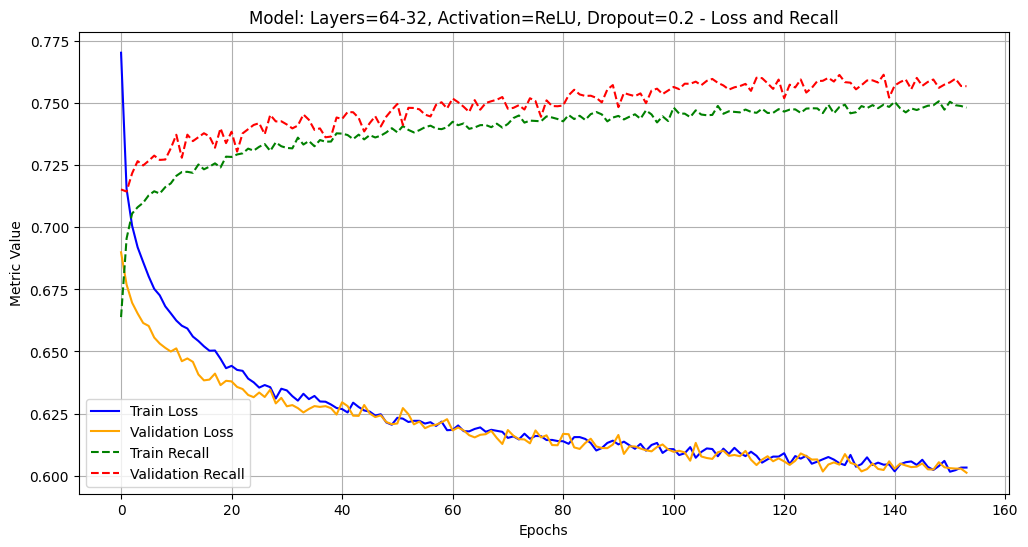


Training Model 2 with config: {'layers': [128, 64, 32], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}
Epoch 1/500 - Train Loss: 0.7776, Train Recall: 0.6608 - Val Loss: 0.6973, Val Recall: 0.7191
Epoch 1 Combined Metric: 0.2941
Epoch 2/500 - Train Loss: 0.7244, Train Recall: 0.6933 - Val Loss: 0.6748, Val Recall: 0.7227
Epoch 2 Combined Metric: 0.3034
Epoch 3/500 - Train Loss: 0.7067, Train Recall: 0.7040 - Val Loss: 0.6645, Val Recall: 0.7291
Epoch 3 Combined Metric: 0.3110
Epoch 4/500 - Train Loss: 0.6988, Train Recall: 0.7075 - Val Loss: 0.6595, Val Recall: 0.7243
Epoch 4 Combined Metric: 0.3092
Epoch 5/500 - Train Loss: 0.6871, Train Recall: 0.7129 - Val Loss: 0.6565, Val Recall: 0.7297
Epoch 5 Combined Metric: 0.3139
Epoch 6/500 - Train Loss: 0.6824, Train Recall: 0.7161 - Val Loss: 0.6531, Val Recall: 0.7301
Epoch 6 Combined Metric: 0.3151
Epoch 7/500 - Train Loss: 0.6724, Train Recall: 0.7172 - Val Loss: 0.6497, Val Recall: 0.7305
Epoch 7 Combined Me

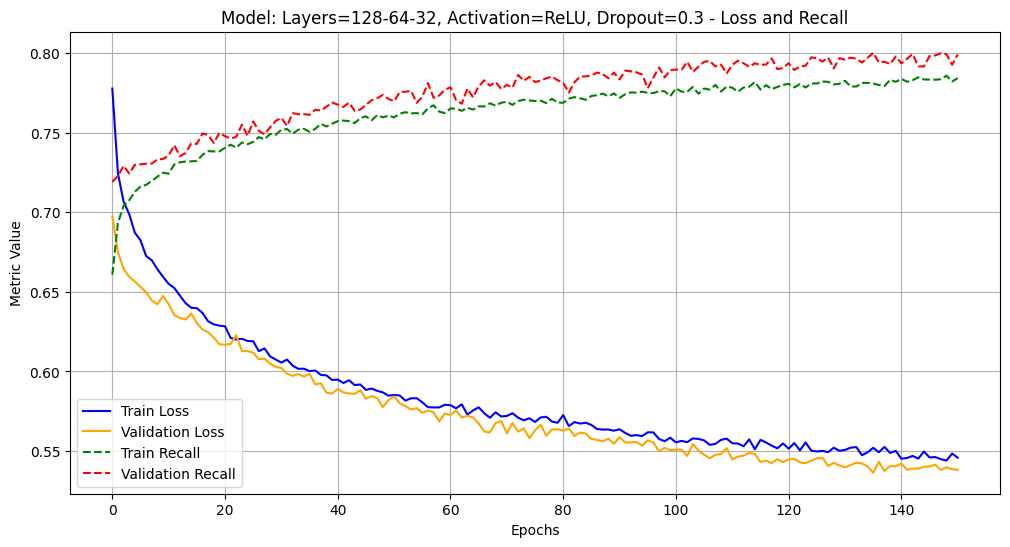


Training Model 3 with config: {'layers': [256, 128, 64], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.4}
Epoch 1/500 - Train Loss: 0.7677, Train Recall: 0.6654 - Val Loss: 0.6921, Val Recall: 0.7170
Epoch 1 Combined Metric: 0.2943
Epoch 2/500 - Train Loss: 0.7167, Train Recall: 0.6969 - Val Loss: 0.6717, Val Recall: 0.7228
Epoch 2 Combined Metric: 0.3044
Epoch 3/500 - Train Loss: 0.7042, Train Recall: 0.7048 - Val Loss: 0.6670, Val Recall: 0.7286
Epoch 3 Combined Metric: 0.3099
Epoch 4/500 - Train Loss: 0.6898, Train Recall: 0.7104 - Val Loss: 0.6549, Val Recall: 0.7262
Epoch 4 Combined Metric: 0.3119
Epoch 5/500 - Train Loss: 0.6796, Train Recall: 0.7146 - Val Loss: 0.6514, Val Recall: 0.7245
Epoch 5 Combined Metric: 0.3118
Epoch 6/500 - Train Loss: 0.6710, Train Recall: 0.7186 - Val Loss: 0.6478, Val Recall: 0.7227
Epoch 6 Combined Metric: 0.3116
Epoch 7/500 - Train Loss: 0.6622, Train Recall: 0.7215 - Val Loss: 0.6390, Val Recall: 0.7313
Epoch 7 Combined M

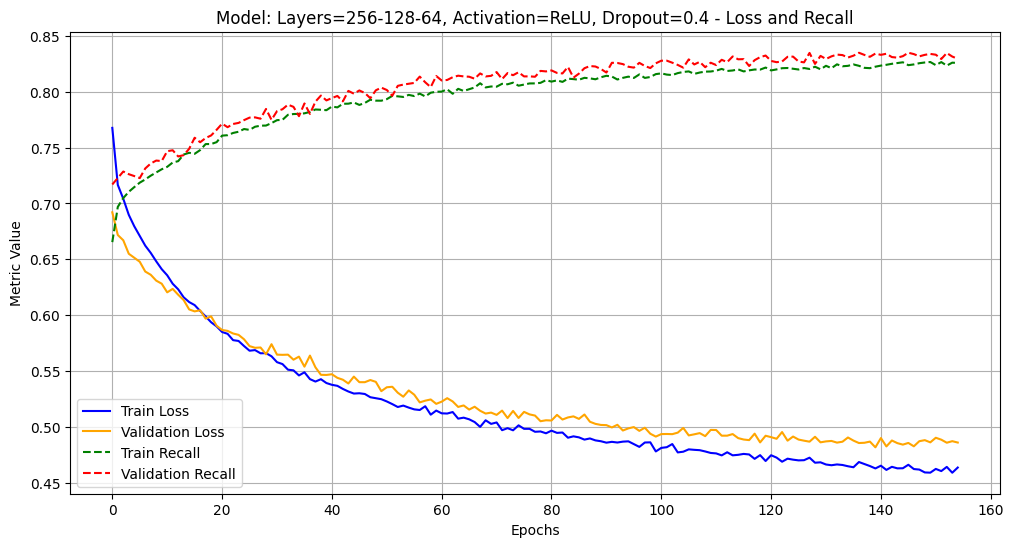


Training Model 4 with config: {'layers': [512, 256, 128, 64], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}
Epoch 1/500 - Train Loss: 0.7544, Train Recall: 0.6738 - Val Loss: 0.6864, Val Recall: 0.7179
Epoch 1 Combined Metric: 0.2966
Epoch 2/500 - Train Loss: 0.7120, Train Recall: 0.6990 - Val Loss: 0.6643, Val Recall: 0.7213
Epoch 2 Combined Metric: 0.3056
Epoch 3/500 - Train Loss: 0.6912, Train Recall: 0.7091 - Val Loss: 0.6646, Val Recall: 0.7217
Epoch 3 Combined Metric: 0.3058
Epoch 4/500 - Train Loss: 0.6787, Train Recall: 0.7141 - Val Loss: 0.6548, Val Recall: 0.7360
Epoch 4 Combined Metric: 0.3188
Epoch 5/500 - Train Loss: 0.6658, Train Recall: 0.7181 - Val Loss: 0.6435, Val Recall: 0.7346
Epoch 5 Combined Metric: 0.3212
Epoch 6/500 - Train Loss: 0.6541, Train Recall: 0.7235 - Val Loss: 0.6364, Val Recall: 0.7299
Epoch 6 Combined Metric: 0.3200
Epoch 7/500 - Train Loss: 0.6421, Train Recall: 0.7287 - Val Loss: 0.6318, Val Recall: 0.7457
Epoch 7 Combi

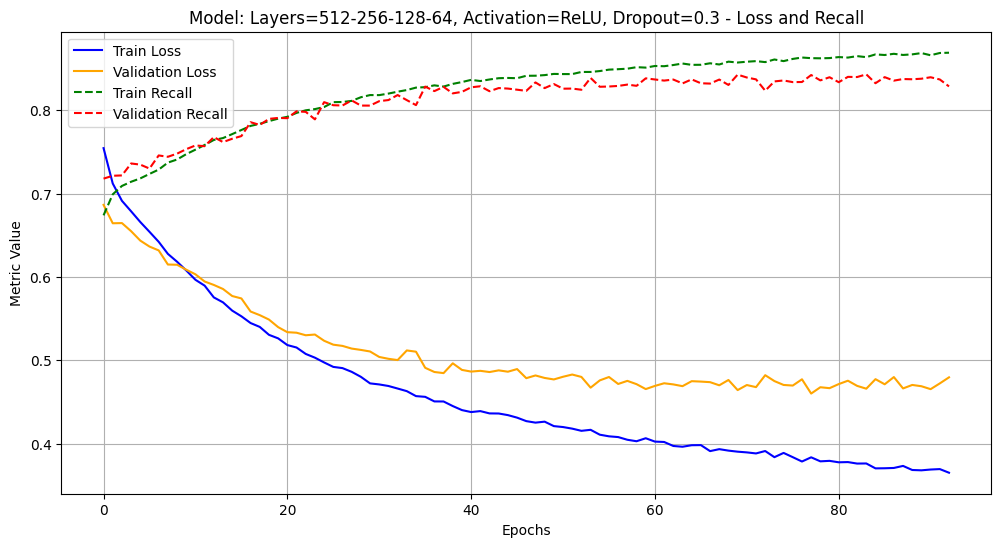


Training Model 5 with config: {'layers': [512, 512, 256, 128], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}
Epoch 1/500 - Train Loss: 0.7491, Train Recall: 0.6775 - Val Loss: 0.6865, Val Recall: 0.7191
Epoch 1 Combined Metric: 0.2974
Epoch 2/500 - Train Loss: 0.7051, Train Recall: 0.7038 - Val Loss: 0.6660, Val Recall: 0.7185
Epoch 2 Combined Metric: 0.3031
Epoch 3/500 - Train Loss: 0.6878, Train Recall: 0.7113 - Val Loss: 0.6599, Val Recall: 0.7238
Epoch 3 Combined Metric: 0.3087
Epoch 4/500 - Train Loss: 0.6707, Train Recall: 0.7180 - Val Loss: 0.6502, Val Recall: 0.7104
Epoch 4 Combined Metric: 0.3023
Epoch 5/500 - Train Loss: 0.6563, Train Recall: 0.7223 - Val Loss: 0.6389, Val Recall: 0.7358
Epoch 5 Combined Metric: 0.3234
Epoch 6/500 - Train Loss: 0.6443, Train Recall: 0.7275 - Val Loss: 0.6315, Val Recall: 0.7311
Epoch 6 Combined Metric: 0.3223
Epoch 7/500 - Train Loss: 0.6307, Train Recall: 0.7352 - Val Loss: 0.6259, Val Recall: 0.7290
Epoch 7 Comb

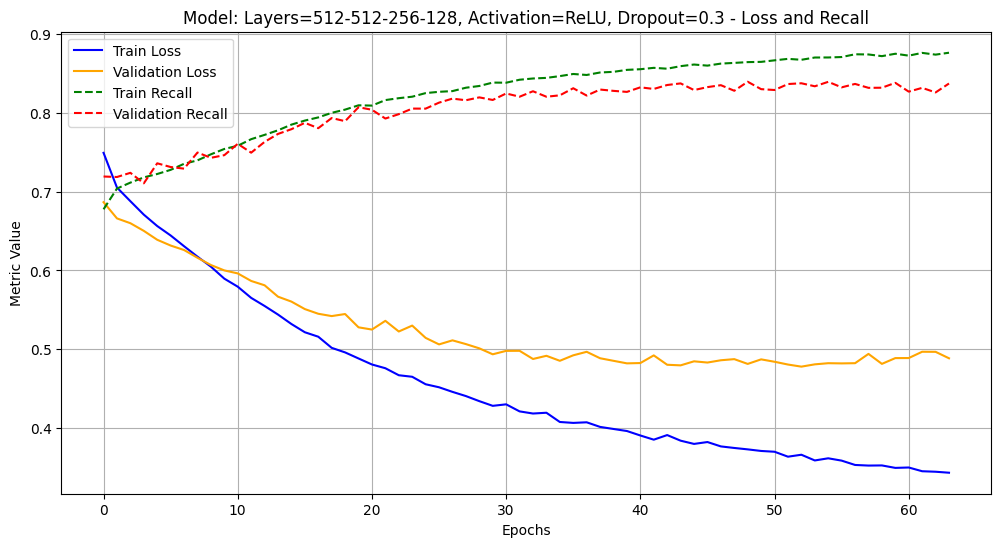


Training Model 6 with config: {'layers': [512, 256, 128, 64, 32], 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'dropout': 0.2}
Epoch 1/500 - Train Loss: 0.7611, Train Recall: 0.6704 - Val Loss: 0.6875, Val Recall: 0.7180
Epoch 1 Combined Metric: 0.2964
Epoch 2/500 - Train Loss: 0.7145, Train Recall: 0.6980 - Val Loss: 0.6757, Val Recall: 0.7155
Epoch 2 Combined Metric: 0.2982
Epoch 3/500 - Train Loss: 0.6948, Train Recall: 0.7068 - Val Loss: 0.6589, Val Recall: 0.7258
Epoch 3 Combined Metric: 0.3104
Epoch 4/500 - Train Loss: 0.6795, Train Recall: 0.7130 - Val Loss: 0.6581, Val Recall: 0.7261
Epoch 4 Combined Metric: 0.3108
Epoch 5/500 - Train Loss: 0.6685, Train Recall: 0.7174 - Val Loss: 0.6521, Val Recall: 0.7297
Epoch 5 Combined Metric: 0.3152
Epoch 6/500 - Train Loss: 0.6573, Train Recall: 0.7222 - Val Loss: 0.6397, Val Recall: 0.7276
Epoch 6 Combined Metric: 0.3174
Epoch 7/500 - Train Loss: 0.6447, Train Recall: 0.7278 - Val Loss: 0.6357, Val Recall: 0.7207
Epoc

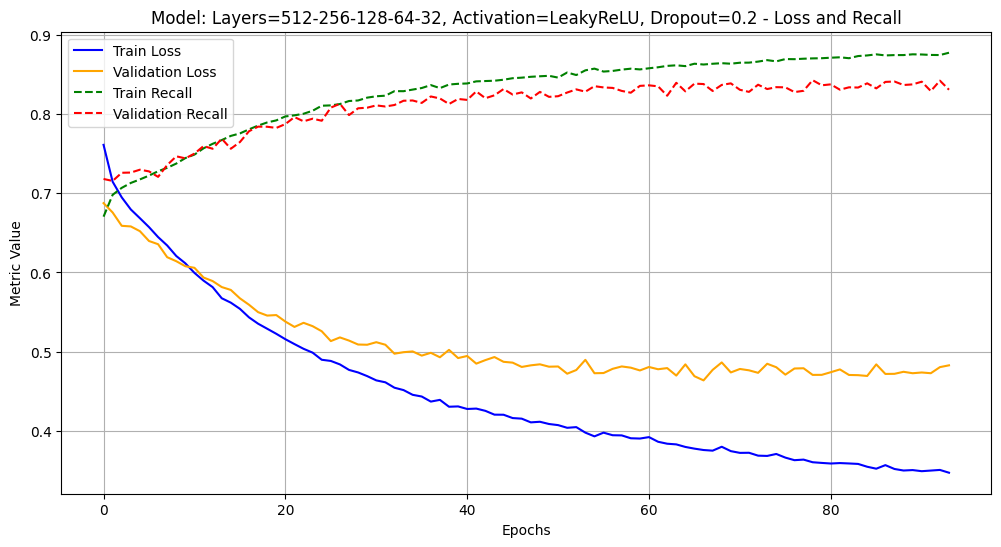


Training Model 7 with config: {'layers': [1024, 512, 256], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.4}
Epoch 1/500 - Train Loss: 0.7503, Train Recall: 0.6722 - Val Loss: 0.6810, Val Recall: 0.7148
Epoch 1 Combined Metric: 0.2961
Epoch 2/500 - Train Loss: 0.7048, Train Recall: 0.6979 - Val Loss: 0.6737, Val Recall: 0.7202
Epoch 2 Combined Metric: 0.3020
Epoch 3/500 - Train Loss: 0.6848, Train Recall: 0.7071 - Val Loss: 0.6643, Val Recall: 0.7166
Epoch 3 Combined Metric: 0.3023
Epoch 4/500 - Train Loss: 0.6710, Train Recall: 0.7142 - Val Loss: 0.6455, Val Recall: 0.7272
Epoch 4 Combined Metric: 0.3154
Epoch 5/500 - Train Loss: 0.6540, Train Recall: 0.7206 - Val Loss: 0.6417, Val Recall: 0.7299
Epoch 5 Combined Metric: 0.3184
Epoch 6/500 - Train Loss: 0.6423, Train Recall: 0.7277 - Val Loss: 0.6306, Val Recall: 0.7456
Epoch 6 Combined Metric: 0.3327
Epoch 7/500 - Train Loss: 0.6258, Train Recall: 0.7339 - Val Loss: 0.6237, Val Recall: 0.7495
Epoch 7 Combined

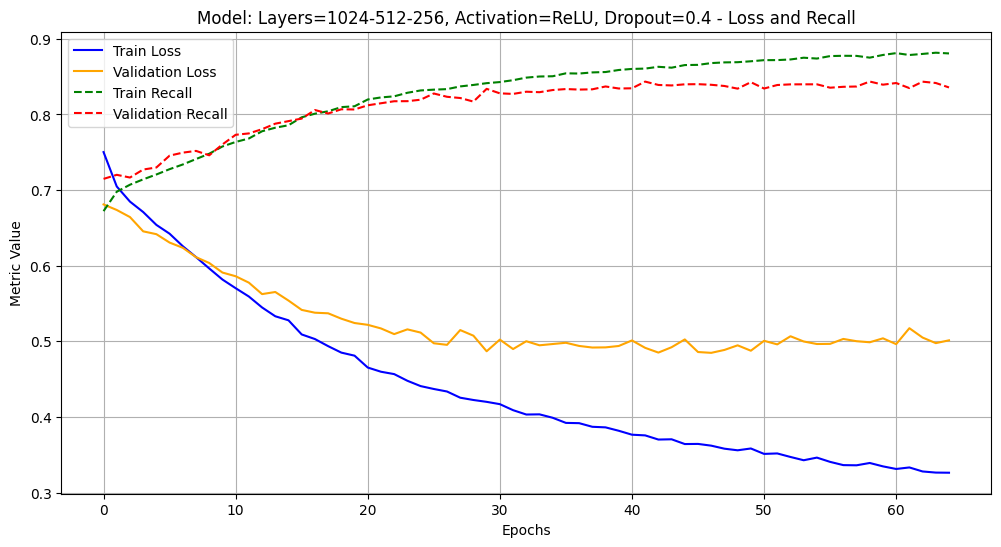


Training Model 8 with config: {'layers': [1024, 512, 256, 128], 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'dropout': 0.3}
Epoch 1/500 - Train Loss: 0.7494, Train Recall: 0.6769 - Val Loss: 0.6838, Val Recall: 0.7161
Epoch 1 Combined Metric: 0.2962
Epoch 2/500 - Train Loss: 0.7054, Train Recall: 0.7017 - Val Loss: 0.6675, Val Recall: 0.7185
Epoch 2 Combined Metric: 0.3027
Epoch 3/500 - Train Loss: 0.6845, Train Recall: 0.7098 - Val Loss: 0.6556, Val Recall: 0.7234
Epoch 3 Combined Metric: 0.3097
Epoch 4/500 - Train Loss: 0.6709, Train Recall: 0.7157 - Val Loss: 0.6535, Val Recall: 0.7314
Epoch 4 Combined Metric: 0.3159
Epoch 5/500 - Train Loss: 0.6564, Train Recall: 0.7241 - Val Loss: 0.6376, Val Recall: 0.7304
Epoch 5 Combined Metric: 0.3200
Epoch 6/500 - Train Loss: 0.6427, Train Recall: 0.7307 - Val Loss: 0.6306, Val Recall: 0.7410
Epoch 6 Combined Metric: 0.3295
Epoch 7/500 - Train Loss: 0.6253, Train Recall: 0.7363 - Val Loss: 0.6199, Val Recall: 0.7382
Epoch 

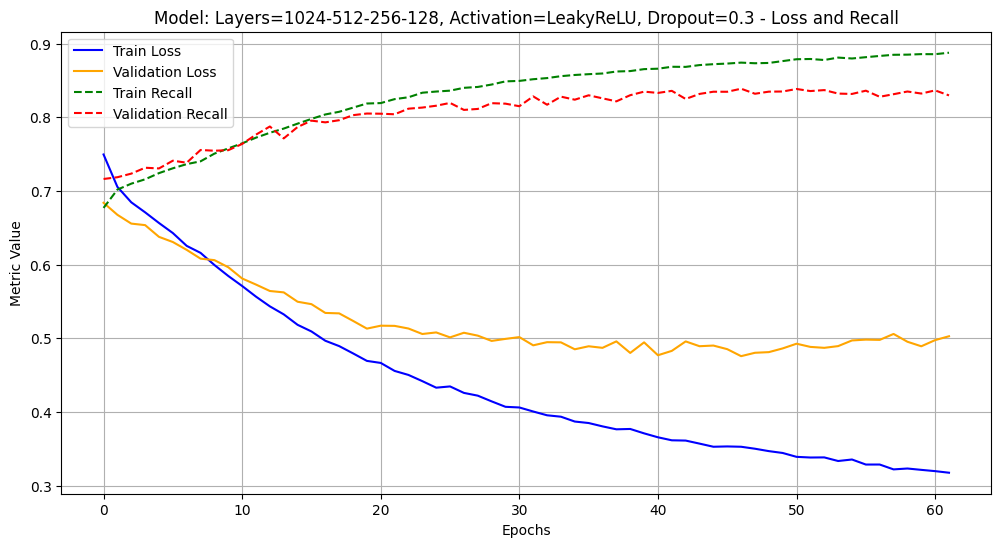


Training Model 9 with config: {'layers': [128, 64], 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'dropout': 0.1}
Epoch 1/500 - Train Loss: 0.7483, Train Recall: 0.6684 - Val Loss: 0.6904, Val Recall: 0.7146
Epoch 1 Combined Metric: 0.2931
Epoch 2/500 - Train Loss: 0.7040, Train Recall: 0.6971 - Val Loss: 0.6735, Val Recall: 0.7166
Epoch 2 Combined Metric: 0.2996
Epoch 3/500 - Train Loss: 0.6857, Train Recall: 0.7063 - Val Loss: 0.6652, Val Recall: 0.7268
Epoch 3 Combined Metric: 0.3092
Epoch 4/500 - Train Loss: 0.6719, Train Recall: 0.7116 - Val Loss: 0.6568, Val Recall: 0.7159
Epoch 4 Combined Metric: 0.3041
Epoch 5/500 - Train Loss: 0.6610, Train Recall: 0.7168 - Val Loss: 0.6562, Val Recall: 0.7316
Epoch 5 Combined Metric: 0.3153
Epoch 6/500 - Train Loss: 0.6559, Train Recall: 0.7195 - Val Loss: 0.6474, Val Recall: 0.7335
Epoch 6 Combined Metric: 0.3192
Epoch 7/500 - Train Loss: 0.6448, Train Recall: 0.7241 - Val Loss: 0.6421, Val Recall: 0.7330
Epoch 7 Combined M

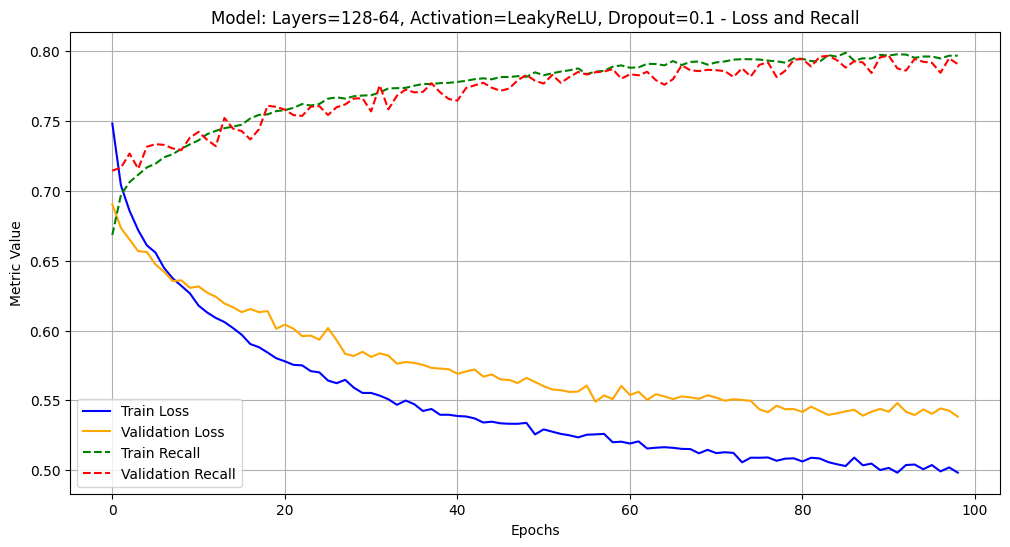

In [15]:
# Experiment configurations
configs = [
    # Original configurations
    {'layers': [64, 32], 'activation': nn.ReLU, 'dropout': 0.2},
    {'layers': [128, 64, 32], 'activation': nn.ReLU, 'dropout': 0.3},
    {'layers': [256, 128, 64], 'activation': nn.ReLU, 'dropout': 0.4},
    
    # Deeper configurations
    {'layers': [512, 256, 128, 64], 'activation': nn.ReLU, 'dropout': 0.3},
    {'layers': [512, 512, 256, 128], 'activation': nn.ReLU, 'dropout': 0.3},
    {'layers': [512, 256, 128, 64, 32], 'activation': nn.LeakyReLU, 'dropout': 0.2},
    
    # Wider configurations
    {'layers': [1024, 512, 256], 'activation': nn.ReLU, 'dropout': 0.4},
    {'layers': [1024, 512, 256, 128], 'activation': nn.LeakyReLU, 'dropout': 0.3},
    
    # Experimental shallow configuration
    {'layers': [128, 64], 'activation': nn.LeakyReLU, 'dropout': 0.1},
]

# Convert scaled data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define early stopping parameters
patience = 15
alpha = 0.7  # Weight for recall in the combined metric

# Train and evaluate models
results = []
for i, config in enumerate(configs):
    print(f"\nTraining Model {i+1} with config: {config}")
    
    # Initialize model with the current configuration
    model = ANNModelImproved(
        input_dim=X_train_tensor.shape[1],
        layers=config['layers'],
        activation=config['activation'],
        dropout_rate=config['dropout']
    )
    
    # Define criterion and optimizer
    class_weights = torch.tensor([1.0, 0.8, 1.2]).to(device)  # Adjust class weights if needed
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model with combined metric-based early stopping
    history, trained_model, best_epoch = train_model_with_combined_criteria(
        model, train_loader, val_loader, epochs=500,
        criterion=criterion, optimizer=optimizer, device=device,
        patience=patience, alpha=alpha
    )
    
    # Extract history metrics for plotting
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    train_recalls = history['train_recall']
    val_recalls = history['val_recall']
    
    # Evaluate the trained model
    f1, recall, recall_poor = evaluate_model(trained_model, val_loader, device)
    combined_metric = alpha * recall - (1 - alpha) * val_losses[-1]  # Use corrected variable names
    results.append({'config': config, 'f1': f1, 'recall': recall, 'recall_poor': recall_poor, 'combined_metric': combined_metric})
    
    # Plot metrics for the current model
    plot_loss_and_recall(
        train_losses, val_losses, train_recalls, val_recalls,
        model_config=config,  # Pass the current configuration
        save_dir="model_plots"  # Specify the directory to save plots
    )



In [16]:
# Compare results and display metrics for all models
print("\nModel Comparison:")
for i, res in enumerate(results):
    print(
        f"Model {i+1}: F1 (Macro) = {res['f1']:.4f}, Recall (Macro) = {res['recall']:.4f}, "
        f"Recall (Poor) = {res['recall_poor']:.4f}, Combined Metric = {res['combined_metric']:.4f}"
    )

# Identify the best model configuration based on the combined metric
best_result = max(results, key=lambda x: x['combined_metric'])  # Use combined metric to determine the best model
best_config = best_result['config']

# Display the best model configuration and its metrics
print("\nBest Model Configuration:")
print(f"Layers: {best_config['layers']}, Activation: {best_config['activation'].__name__}, Dropout: {best_config['dropout']}")
print(f"Best Combined Metric: {best_result['combined_metric']:.4f}")
print(f"Corresponding F1 (Macro): {best_result['f1']:.4f}, Recall (Macro): {best_result['recall']:.4f}, Recall (Poor): {best_result['recall_poor']:.4f}")



Model Comparison:
Model 1: F1 (Macro) = 0.7208, Recall (Macro) = 0.7568, Recall (Poor) = 0.7657, Combined Metric = 0.3494
Model 2: F1 (Macro) = 0.7607, Recall (Macro) = 0.7991, Recall (Poor) = 0.8604, Combined Metric = 0.3979
Model 3: F1 (Macro) = 0.7977, Recall (Macro) = 0.8295, Recall (Poor) = 0.8849, Combined Metric = 0.4349
Model 4: F1 (Macro) = 0.8067, Recall (Macro) = 0.8284, Recall (Poor) = 0.8872, Combined Metric = 0.4360
Model 5: F1 (Macro) = 0.8123, Recall (Macro) = 0.8370, Recall (Poor) = 0.8920, Combined Metric = 0.4393
Model 6: F1 (Macro) = 0.8121, Recall (Macro) = 0.8306, Recall (Poor) = 0.8950, Combined Metric = 0.4366
Model 7: F1 (Macro) = 0.8120, Recall (Macro) = 0.8357, Recall (Poor) = 0.8636, Combined Metric = 0.4346
Model 8: F1 (Macro) = 0.8113, Recall (Macro) = 0.8296, Recall (Poor) = 0.8735, Combined Metric = 0.4299
Model 9: F1 (Macro) = 0.7707, Recall (Macro) = 0.7909, Recall (Poor) = 0.7946, Combined Metric = 0.3921

Best Model Configuration:
Layers: [512, 512,

In [17]:
# Combine training and validation sets
X_final_train = np.vstack((X_train_scaled, X_val_scaled))
y_final_train = np.hstack((y_train, y_val))

# Convert combined dataset to PyTorch tensors
X_final_train_tensor = torch.tensor(X_final_train, dtype=torch.float32)
y_final_train_tensor = torch.tensor(y_final_train, dtype=torch.long)

# Create DataLoader for final training dataset
final_train_dataset = TensorDataset(X_final_train_tensor, y_final_train_tensor)
final_train_loader = DataLoader(final_train_dataset, batch_size=32, shuffle=True)


In [20]:
def train_model_with_combined_criteria(
    model, train_loader, val_loader, epochs, criterion, optimizer, device, patience=5, alpha=0.5
):
    """
    Train the model with early stopping based on combined validation loss and recall.
    
    Args:
    - model: PyTorch model.
    - train_loader, val_loader: DataLoaders for training and validation data.
    - epochs: Maximum number of epochs.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - device: Device (CPU/GPU).
    - patience: Number of epochs to wait for improvement in metrics.
    - alpha: Weight for recall in the combined metric (0 ≤ alpha ≤ 1).

    Returns:
    - history: Dictionary containing training/validation losses and recalls.
    - model: The best model based on the combined metric.
    - best_epoch: The epoch where the best model was achieved.
    """
    assert 0 <= alpha <= 1, "alpha must be between 0 and 1"
    assert patience > 0, "patience must be a positive integer"

    best_combined_metric = float('-inf')  # Higher is better
    best_epoch = 0
    early_stop_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_recall': [], 'val_recall': []}

    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, y_true_train, y_pred_train = 0, [], []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            preds = torch.argmax(output, dim=1)
            y_true_train.extend(y_batch.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())
        history['train_loss'].append(train_loss / len(train_loader))
        train_recall = recall_score(y_true_train, y_pred_train, average='macro')
        history['train_recall'].append(train_recall)
        
        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss, y_true_val, y_pred_val = 0, [], []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    output = model(X_batch)
                    loss = criterion(output, y_batch)
                    val_loss += loss.item()
                    
                    preds = torch.argmax(output, dim=1)
                    y_true_val.extend(y_batch.cpu().numpy())
                    y_pred_val.extend(preds.cpu().numpy())
            history['val_loss'].append(val_loss / len(val_loader))
            val_recall = recall_score(y_true_val, y_pred_val, average='macro')
            history['val_recall'].append(val_recall)
        else:
            val_loss, val_recall = float('inf'), 0.0  # Default values when no val_loader

        # Print metrics for the current epoch
        if val_loader is not None:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {history['train_loss'][-1]:.4f}, Train Recall: {train_recall:.4f} "
                  f"- Val Loss: {history['val_loss'][-1]:.4f}, Val Recall: {val_recall:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {history['train_loss'][-1]:.4f}, Train Recall: {train_recall:.4f}")

        # Combined metric: Weighted combination of recall and loss
        combined_metric = alpha * train_recall - (1 - alpha) * train_loss  # No val metrics when val_loader=None
        print(f"Epoch {epoch+1} Combined Metric: {combined_metric:.4f}")
        
        # Early stopping based on combined metric
        if combined_metric > best_combined_metric:
            best_combined_metric = combined_metric
            best_model = model.state_dict()
            best_epoch = epoch + 1
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                break

    # Fallback: Save the best model if no improvements were seen
    if best_combined_metric == float('-inf'):
        best_model = model.state_dict()

    # Load the best model
    model.load_state_dict(best_model)
    return history, model, best_epoch


In [22]:
# Initialize the final model with the best configuration
final_model = ANNModelImproved(
    input_dim=X_final_train_tensor.shape[1],
    layers=best_config['layers'],
    activation=best_config['activation'],
    dropout_rate=best_config['dropout']
)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Use the same class weights
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

# Train the final model using combined training data
patience = 15  # Set patience for early stopping
alpha = 0.7    # Weight for recall in combined metric

# Train the model
history, final_model, best_epoch = train_model_with_combined_criteria(
    final_model, final_train_loader, None,  # No validation loader
    epochs=500, criterion=criterion, optimizer=optimizer,
    patience=patience, alpha=alpha, device=device
)

# Extract history metrics
train_losses = history['train_loss']
train_recalls = history['train_recall']


Epoch 1/500 - Train Loss: 0.7411, Train Recall: 0.6817
Epoch 1 Combined Metric: -489.9961
Epoch 2/500 - Train Loss: 0.7011, Train Recall: 0.7050
Epoch 2 Combined Metric: -463.5034
Epoch 3/500 - Train Loss: 0.6808, Train Recall: 0.7128
Epoch 3 Combined Metric: -450.0390
Epoch 4/500 - Train Loss: 0.6660, Train Recall: 0.7210
Epoch 4 Combined Metric: -440.2789
Epoch 5/500 - Train Loss: 0.6515, Train Recall: 0.7268
Epoch 5 Combined Metric: -430.6685
Epoch 6/500 - Train Loss: 0.6352, Train Recall: 0.7336
Epoch 6 Combined Metric: -419.8784
Epoch 7/500 - Train Loss: 0.6197, Train Recall: 0.7418
Epoch 7 Combined Metric: -409.5777
Epoch 8/500 - Train Loss: 0.6033, Train Recall: 0.7487
Epoch 8 Combined Metric: -398.7355
Epoch 9/500 - Train Loss: 0.5871, Train Recall: 0.7581
Epoch 9 Combined Metric: -387.9833
Epoch 10/500 - Train Loss: 0.5763, Train Recall: 0.7640
Epoch 10 Combined Metric: -380.8404
Epoch 11/500 - Train Loss: 0.5612, Train Recall: 0.7714
Epoch 11 Combined Metric: -370.8431
Epoch 

AssertionError: Metric lists must have the same length.

Plot saved to final_model_plots/Model_Layers_512-512-256-128_Activation_ReLU_Dropout_0.3.png


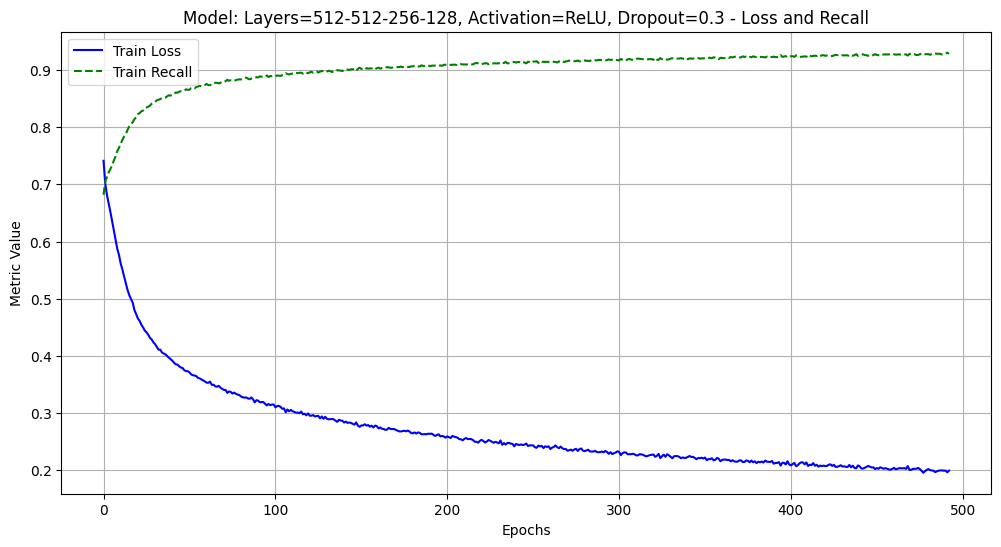

In [24]:

# Plot final training metrics (omit validation metrics since no val_loader is provided)
plot_loss_and_recall(
    train_losses, [],  # No validation losses
    train_recalls, [],  # No validation recalls
    model_config={'layers': best_config['layers'], 'activation': best_config['activation'], 'dropout': best_config['dropout']},
    save_dir="final_model_plots"
)

In [25]:
import torch.nn.functional as F  # For Softmax

def predict_and_evaluate(model, test_loader, device):
    """
    
    Predict on the test set and evaluate performance.

    Args:
    - model: Trained PyTorch model.
    - test_loader: DataLoader for the test set.
    - device: Device (CPU/GPU).

    Returns:
    - metrics: Dictionary containing F1-score (macro/weighted), recall for "Poor" class, accuracy, and classification report.
    - y_true: List of true labels (optional, for further analysis).
    - y_pred: List of predicted labels (optional, for further analysis).
    """
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []
    probabilities = []  # To store class probabilities
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)  # Raw logits
            probs = F.softmax(output, dim=1)  # Apply Softmax to logits
            preds = torch.argmax(probs, axis=1)  # Get class predictions
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())  # Store probabilities
    
    # Calculate evaluation metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')  # Macro F1-Score
    f1_weighted = f1_score(y_true, y_pred, average='weighted')  # Weighted F1-Score
    recall_poor = recall_score(y_true, y_pred, average=None)[0]  # Recall for "Poor" class (class 0)
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))  # Overall accuracy

    # Print classification report
    print("\nClassification Report on Test Set:")
    report = classification_report(y_true, y_pred, target_names=['Poor', 'Standard', 'Good'])
    print(report)
    
    # Return all metrics
    metrics = {
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'recall_poor': recall_poor,
        'accuracy': accuracy,
        'classification_report': report
    }
    return metrics, y_true, y_pred, probabilities


In [27]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle for testing


In [28]:
# Evaluate the final model on the test set
test_metrics, y_true, y_pred, probabilities = predict_and_evaluate(final_model, test_loader, device)

# Display final test set metrics
print(f"Final Test Set F1-Score (Macro): {test_metrics['f1_macro']:.4f}")
print(f"Final Recall for 'Poor' Class: {test_metrics['recall_poor']:.4f}")



Classification Report on Test Set:
              precision    recall  f1-score   support

        Poor       0.80      0.87      0.83      6588
    Standard       0.87      0.80      0.84     12538
        Good       0.78      0.85      0.81      4405

    accuracy                           0.83     23531
   macro avg       0.82      0.84      0.83     23531
weighted avg       0.83      0.83      0.83     23531

Final Test Set F1-Score (Macro): 0.8272
Final Recall for 'Poor' Class: 0.8693


In [29]:
!pip install torchinfo


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [35]:
from torchinfo import summary

# Display model summary
summary(final_model, input_size=(32, X_final_train_tensor.shape[1]))


Layer (type:depth-idx)                   Output Shape              Param #
ANNModelImproved                         [32, 3]                   --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 512]                 24,064
│    └─BatchNorm1d: 2-2                  [32, 512]                 1,024
│    └─ReLU: 2-3                         [32, 512]                 --
│    └─Linear: 2-4                       [32, 512]                 262,656
│    └─BatchNorm1d: 2-5                  [32, 512]                 1,024
│    └─ReLU: 2-6                         [32, 512]                 --
│    └─Dropout: 2-7                      [32, 512]                 --
│    └─Linear: 2-8                       [32, 256]                 131,328
│    └─BatchNorm1d: 2-9                  [32, 256]                 512
│    └─ReLU: 2-10                        [32, 256]                 --
│    └─Dropout: 2-11                     [32, 256]              

In [31]:
# Specify the path to save the model
model_save_path = "final_model.pth"

# Save the model's state dictionary
torch.save(final_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to final_model.pth


In [34]:
import sys
!{sys.executable} -m pip install torchinfo


  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)
